In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import textwrap


from dataloader import INSPIRE
from model import *

from tqdm import tqdm
import numpy as np
import json
import copy

from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score, recall_score, \
                            precision_score, f1_score, roc_auc_score, \
                            average_precision_score

from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

# 设置绘图区域背景为白色
plt.rcParams['figure.facecolor'] = 'white'

def calculate_integrated_gradients(input_list, model, target_class_index, steps=50, device='cuda:0'):
    # 将所有的 Tensor 移到 GPU 上并初始化基线和梯度向量
    for i in range(len(input_list)):
        input_list[i] = input_list[i].to(device)

    baseline_list = [torch.zeros_like(input_tensor, device=device) for input_tensor in input_list]
    integrated_gradients_list = [torch.zeros_like(input_tensor) for input_tensor in input_list]
    diff_list = [(input_tensor - baseline_tensor) / steps for input_tensor, baseline_tensor in zip(input_list, baseline_list)]

    # 对于每个步骤，计算模型的预测和梯度
    for step in range(steps):
        for i in range(len(input_list)):
            # 创建当前步骤的输入列表，其中只有第i个元素是变化的
            current_step_input = input_list[:]  # 使用原始输入列表的副本
            current_step_input[i] = baseline_list[i] + step * diff_list[i]  # 只更新第i个元素
            current_step_input[i].requires_grad_()  # 为当前变量启用梯度跟踪

            # 执行模型前向传播
            preds = model(current_step_input)
            target_preds = preds[0][:, target_class_index]  # 选择目标类别的预测值

            # 计算梯度
            grads = torch.autograd.grad(target_preds, current_step_input[i], retain_graph=True)[0]
            integrated_gradients_list[i] += grads

    # 将计算的梯度除以步数并转移到 CPU
    for i in range(len(integrated_gradients_list)):
        integrated_gradients_list[i] = (integrated_gradients_list[i] / steps).to('cpu')

    return integrated_gradients_list




In [2]:
dataset_te = INSPIRE("/home/luojiawei/pengxiran_project_data/all_op_id1/",
                    "/home/luojiawei/pengxiran_project_data/ds_id.csv",
                    id_col="op_id",
                    mod_col="set",
                    mod = [2],
                    cls_col = None,
                    cls = None,
                    stat_path = "/home/luojiawei/pengxiran_project/deep_learning/stat_info"
                    )

all_id 的数量: 20267


/home/luojiawei/anaconda3/envs/py37/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3473: DtypeWarning: Columns (43) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [5]:
# lab_pre/post 36 + 36, vit_pre 76 + 75, vit_in 75 + 75, vit_post 75 + 75, x_s 37, oper 5
input_size_list = [36 + 36 + 48, 76 + 75,75 + 75, 75 + 75, 36+36+4]#
hidden_size_list = [256, 256,256,256 ,256]#
output_size_list = [1]
type_list = ["cat"]
model_list = ["mlp","biattlstm","biattlstm","biattlstm","mlp"]#

In [6]:
device = torch.device("cuda:1")

In [33]:
model = PredModel(input_size_list, hidden_size_list, model_list, output_size_list, type_list)
model.load_state_dict(torch.load("/home/luojiawei/pengxiran_project/deep_learning/saved_param/model_AKI_2_post.pth"))
model = model.to(device)

In [34]:
fn_1 = pd.read_csv("/home/luojiawei/pengxiran_project/fn1.csv",header=0).iloc[:,1]
fn_2 = pd.read_csv("/home/luojiawei/pengxiran_project/fn2.csv",header=0).iloc[:,1]
fn_3 = pd.read_csv("/home/luojiawei/pengxiran_project/fn3.csv",header=0).iloc[:,1]
fn_4 = pd.read_csv("/home/luojiawei/pengxiran_project/fn4.csv",header=0).iloc[:,1]
fn_5 = pd.read_csv("/home/luojiawei/pengxiran_project/fn5.csv",header=0).iloc[:,1]

In [35]:
# k = dataset_te.all_id.index(423695004)

# lab_pre, mask_lab_pre, lab_post, mask_lab_post, \
#     vit_pre, mask_pre, vit_in, mask_in, vit_post, mask_post, \
#     t_list, x_s, oper_info, \
#     y_mat, y_mask, y_static, y_mask1 = dataset_te.get_1data(k, normalize=True)

# lab_pre = lab_pre.to(device)
# mask_lab_pre = mask_lab_pre.to(device)
# lab_post = lab_post.to(device)
# mask_lab_post = mask_lab_post.to(device)

# vit_pre = vit_pre.unsqueeze(0).to(device)
# mask_pre = mask_pre.unsqueeze(0).to(device)
# vit_in = vit_in.unsqueeze(0).to(device)
# mask_in = mask_in.unsqueeze(0).to(device)  
# vit_post = vit_post.unsqueeze(0).to(device)
# mask_post = mask_post.unsqueeze(0).to(device)

# x_s = x_s.to(device)
# oper_info = oper_info.to(device)

# x_1 = torch.cat([lab_pre, mask_lab_pre, x_s], dim=-1)
# x_2 = torch.cat([vit_pre, mask_pre], dim=-1)
# x_3 = torch.cat([vit_in, mask_in], dim=-1)
# x_4 = torch.cat([vit_post, mask_post], dim=-1)
# x_5 = torch.cat([lab_post, mask_lab_post, oper_info], dim=-1)

In [37]:
# grads = calculate_integrated_gradients([x_1,x_2,x_3,x_4,x_5], model, 0, steps=50, device=device)
# grads[1] = grads[1].sum((0,1))
# grads[2] = grads[2].sum((0,1))
# grads[3] = grads[3].sum((0,1))
# fea_imp = np.concatenate([grads[0][0], grads[1], grads[2], grads[3], grads[4][0]], axis=0)
# fn = fn_1.tolist() + fn_2.tolist() + fn_3.tolist() + fn_4.tolist() + fn_5.tolist()


In [32]:
# import matplotlib.pyplot as plt
# import seaborn as sns

# # 计算特征重要性的绝对值的平均
# abs_imp = np.abs(fea_imp)

# # 选择前 n 个最重要的特征
# n = 20
# top_indices = np.argsort(-abs_imp)[:n]

# colors = ['lightcoral' if x > 0 else 'lightblue' for x in fea_imp[top_indices]]

# plt.figure(figsize=(5, 10))
# bar_plot = sns.barplot(x=fea_imp[top_indices], y=[fn[i] for i in top_indices], palette=colors)
# plt.title('Bar Plot of Importance for Top Features')
# plt.xlabel('Feature Importance (x1e-3)', fontsize=14)  # 修改单位说明
# plt.ylabel('Features', fontsize=14)
# plt.axvline(x=0, color='grey', linestyle='--')  # 加一个 x=0的中心竖线，用虚线
# plt.grid(True, which='both', linestyle='--', linewidth=0.5, color='lightgrey')  # 添加灰色网格线
# # 将横坐标的值乘以1000，保留两位小数
# plt.xticks(ticks=plt.xticks()[0], labels=[f"{x*1000:.2f}" for x in plt.xticks()[0]], rotation=45)

# plt.show()

In [38]:
fea_imp = []
import random
count = 1
random.seed(42)
for i in random.sample(range(dataset_te.len()), 200): 
    lab_pre, mask_lab_pre, lab_post, mask_lab_post, \
        vit_pre, mask_pre, vit_in, mask_in, vit_post, mask_post, \
        t_list, x_s, oper_info, \
        y_mat, y_mask, y_static, y_mask1 = dataset_te.get_1data(i, normalize=True)

    lab_pre = lab_pre.to(device)
    mask_lab_pre = mask_lab_pre.to(device)
    lab_post = lab_post.to(device)
    mask_lab_post = mask_lab_post.to(device)

    vit_pre = vit_pre.unsqueeze(0).to(device)
    mask_pre = mask_pre.unsqueeze(0).to(device)
    vit_in = vit_in.unsqueeze(0).to(device)
    mask_in = mask_in.unsqueeze(0).to(device)  
    vit_post = vit_post.unsqueeze(0).to(device)
    mask_post = mask_post.unsqueeze(0).to(device)       

    x_s = x_s.to(device)
    oper_info = oper_info.to(device)

    x_1 = torch.cat([lab_pre, mask_lab_pre, x_s], dim=-1)
    x_2 = torch.cat([vit_pre, mask_pre], dim=-1)
    x_3 = torch.cat([vit_in, mask_in], dim=-1)
    x_4 = torch.cat([vit_post, mask_post], dim=-1)
    x_5 = torch.cat([lab_post, mask_lab_post, oper_info], dim=-1)

    grads = calculate_integrated_gradients([x_1,x_2,x_3,x_4,x_5], model, 0, steps=50, device=device)
    grads[1] = grads[1].sum((0,1))
    grads[2] = grads[2].sum((0,1))
    grads[3] = grads[3].sum((0,1))
    fea_imp.append(np.concatenate([grads[0][0], grads[1], grads[2],grads[3],grads[4][0]], axis=0))
    if count % 10 == 0:
        print(count)
    count += 1


In [39]:
fea_imp = np.stack(fea_imp, axis=0)
np.save('/home/luojiawei/pengxiran_project/结果文件夹/fea_imp_folder/fea_imp_AKI_2_post.npy', fea_imp)

In [124]:
fea_imp = np.load('/home/luojiawei/pengxiran_project/结果文件夹/fea_imp_folder/fea_imp_in_hospital_death_surg_end.npy')


In [125]:
fn = fn_1.tolist() + fn_2.tolist()+ fn_3.tolist()# + fn_4.tolist() + fn_5.tolist()
# mean_imp = np.abs(fea_imp).mean(0)
# sorted_indices = np.argsort(-np.abs(mean_imp))  # 绝对值由大到小排序
# top_fn = [fn[i] for i in sorted_indices[:20] if i < len(fn)]  # 选出排名前20的 fn，确保索引不会超出范围


In [126]:
# import matplotlib.pyplot as plt
# import seaborn as sns
# import matplotlib.ticker as ticker

# # 计算特征重要性的绝对值的平均
# mean_abs_imp = np.abs(fea_imp).mean(axis=0)

# # 选择前 n 个最重要的特征
# n = 50
# top_indices = np.argsort(-mean_abs_imp)[:n]
# feature_names = [fn[i] for i in top_indices]

# # 创建一个图和两个子图
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 20), sharey=True)

# # 在第一个子图上绘制 boxplot
# sns.boxplot(data=fea_imp[:, top_indices], orient='h', fliersize=0, ax=ax1)
# ax1.set_yticks(ticks=range(n))
# ax1.set_yticklabels(feature_names, fontsize=16)  # 放大 y 轴标签的字体大小
# ax1.set_xticklabels(ax1.get_xticks(), fontsize=12)  # 放大 x 轴标签的字体大小
# ax1.xaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))  # 设置 x 轴标签的格式
# # ax1.set_title('Boxplot of Importance for Top Features')
# ax1.set_xlabel('Feature Importance', fontsize=16)
# ax1.set_xlim(-0.1, 0.1)
# ax1.axvline(x=0, color='black', linestyle='--')
# ax1.grid(True, which='both', linestyle='--', linewidth=0.5, color='lightgrey')

# # 在第二个子图上绘制 barplot
# sns.barplot(x=mean_abs_imp[top_indices], y=feature_names, ax=ax2)
# ax2.set_yticklabels(feature_names, fontsize=16)  # 确保 y 轴标签字体大小与左侧一致
# ax2.set_xticklabels(ax2.get_xticks(), fontsize=12)  # 放大 x 轴标签的字体大小
# # ax2.set_title('Bar Plot of Mean Absolute Importance for Top Features')
# ax2.set_xlabel('Mean Absolute Importance', fontsize=16)
# ax2.grid(True, which='both', linestyle='--', linewidth=0.5, color='lightgrey')  # 添加灰色网格线

# plt.tight_layout()
# plt.show()

In [127]:
# fea_imp_range = [(fea_imp[:, i].min(), fea_imp[:, i].max(), fn[i]) for i in range(fea_imp.shape[1])]
# fea_imp_range


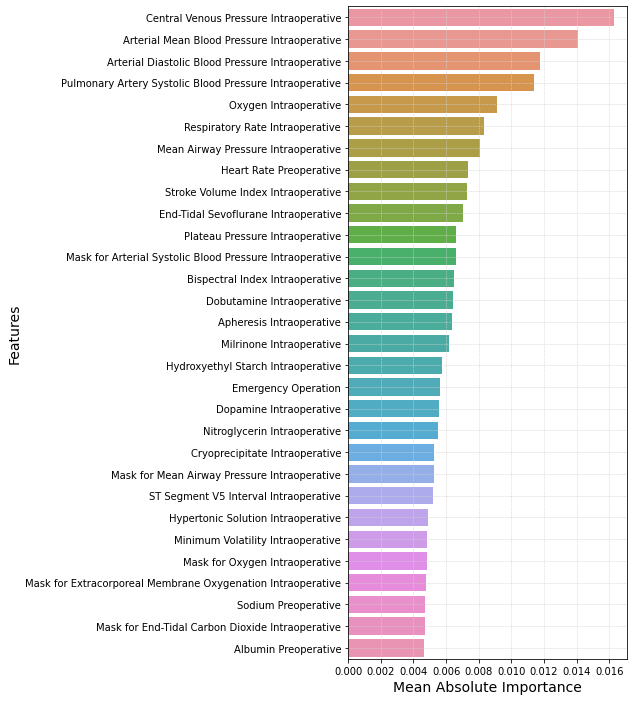

In [128]:
import matplotlib.pyplot as plt
import seaborn as sns

# 计算特征重要性的绝对值的平均
mean_abs_imp = np.abs(fea_imp).mean(axis=0)

# 选择前 n 个最重要的特征
n = 30
top_indices = np.argsort(-mean_abs_imp)[:n]
feature_names = [fn[i] for i in top_indices]

# 创建 barplot
plt.figure(figsize=(5, 12))
sns.barplot(x=mean_abs_imp[top_indices], y=feature_names)
# plt.title('Bar Plot of Mean Absolute Importance for Top Features')
plt.xlabel('Mean Absolute Importance', fontsize=14)
plt.ylabel('Features', fontsize=14)
plt.grid(True, which='both', linestyle='--', linewidth=0.5, color='lightgrey')  # 添加灰色网格线
plt.show()